In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Generating Noise

In [2]:
def gen_noise(psd_need):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    if (psd_need == True) :
        pp.plot(psd.sample_frequencies,psd.data)
        pp.loglog()
        pp.xlim(30,2000)
        pp.ylabel('$Strain^2 / Hz$')
        pp.xlabel('Frequency (Hz)')
        pp.show()


    # Generate 512 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(512/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
    
    #plotting noise 
#     pp.plot(ts.sample_times, ts)
#     pp.ylabel('Strain')
#     pp.xlabel('Time (s)')
#     pp.show()
    

    return ts

noise = gen_noise(False)

# Generating Strain

fp=0.5494252193754385, fc=-0.5320202660769405


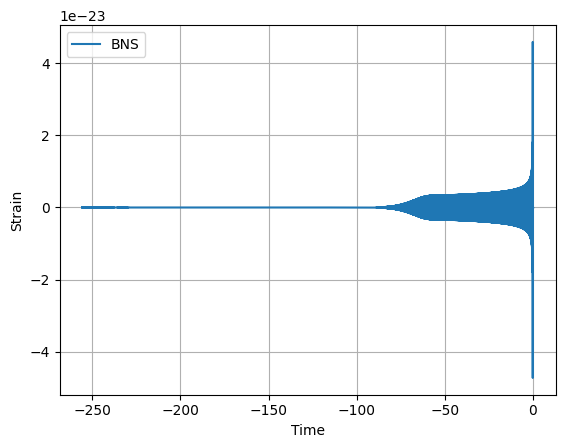

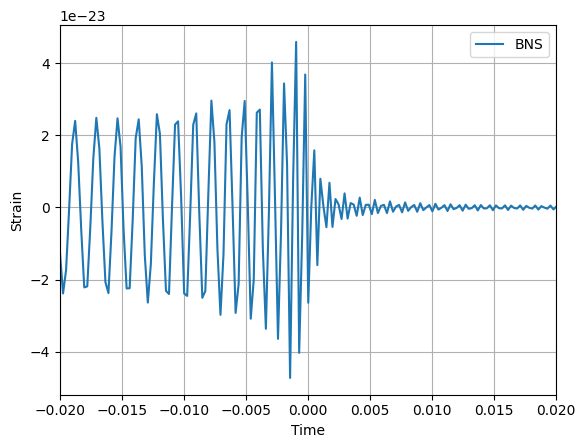

fp=0.5494252193754385, fc=-0.5320202660769405


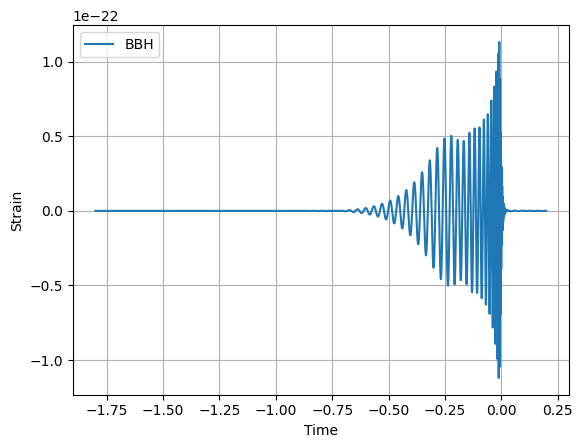

In [3]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform


   
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0




    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    print("fp={}, fc={}".format(fp, fc))

    # These factors allow us to project a signal into what the detector would observe
    # IMRPhenomPv2
    # Generate the waveform for the BNS merger
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ## Apply the factors to get the detector frame strain
    ht_1 = fp * hp_1 + fc * hc_1
    
    
    pp.plot(ht_1.sample_times, ht_1, label=l)
    pp.legend()
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    
    
    return ht_1

# generating BNS signal

h1_bns = gen_waveform('TaylorF2',1.4,1.3,0.05,0.05,350,0.0,"BNS")

pp.plot(h1_bns.sample_times, h1_bns, label='BNS')
pp.legend()
pp.xlim(-0.02,0.02)
pp.ylabel('Strain')
pp.xlabel('Time')
pp.grid()
pp.show()




h1_bbh = gen_waveform('IMRPhenomPv2',30,40,0.8,0.8,5500,0.0,"BBH")



# Combining the Signals

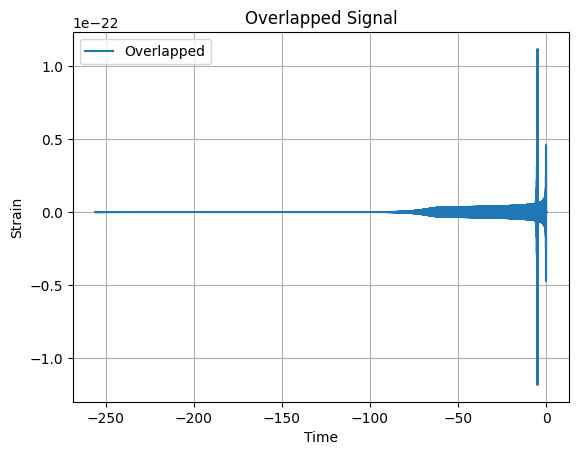

-255.8


In [4]:
def overlap(ht_1,ht_2,buffer):
    
    #Equal lengths of signals
    ht_2.resize(len(ht_1))
    
    #Shifting the merger time
    ht_2=ht_2.cyclic_time_shift(ht_2.end_time - buffer)
    
    #Equating the start time of both signals
    ht_2.start_time = ht_1.start_time
    
    #Combining the signals
    ht_total = ht_1 + ht_2

    #Ploting the signals
    pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
    pp.legend()
    pp.title('Overlapped Signal')
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    return ht_total,ht_2

ht_total,h1_bbh = overlap(h1_bns,h1_bbh,5)
print(ht_total.start_time)

signal_1_peak = ht_total.start_time * (-1)

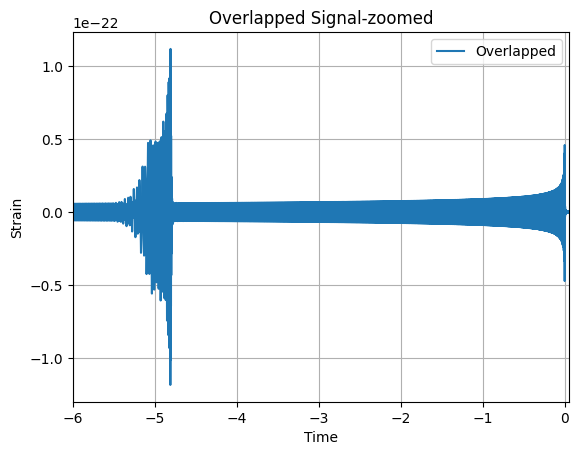

In [5]:
pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
pp.xlim(-6,0.05)
#pp.ylim(-0.5*(10**-21),0.5*(10**-21))
pp.legend()
pp.ylabel('Strain')
pp.xlabel('Time')
pp.title('Overlapped Signal-zoomed')
pp.grid()
pp.show()



# Injecting strain into noise

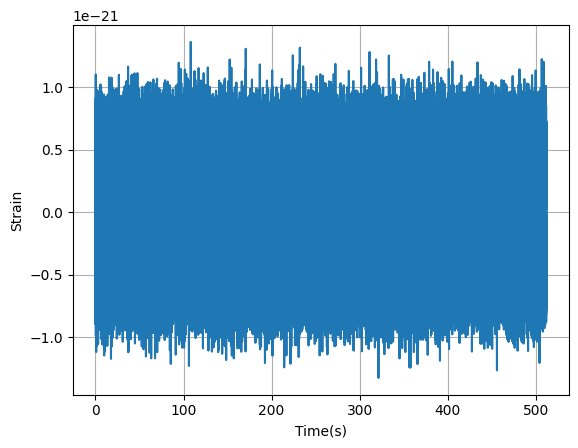

In [6]:
def inject(ht_total,ts):
    
    #Resizing the signal
    ht_total.resize(len(ts)) 
    
    #Equating the start time
    ht_total.start_time = ts.start_time
    
    #Injecting signal into noise
    ts = ts.add_into(ht_total) 
    
    #plotting the result
    pp.plot(ts.sample_times, ts)
    pp.xlabel('Time(s)')
    pp.ylabel('Strain')
    pp.grid()
    pp.show()
    
    return ts 

ts1 = inject(ht_total,noise)

# signal_2_peak = signal_1_peak-0.8



# print(signal_1_peak)
# print(signal_2_peak)


# Calculating Power spectral density

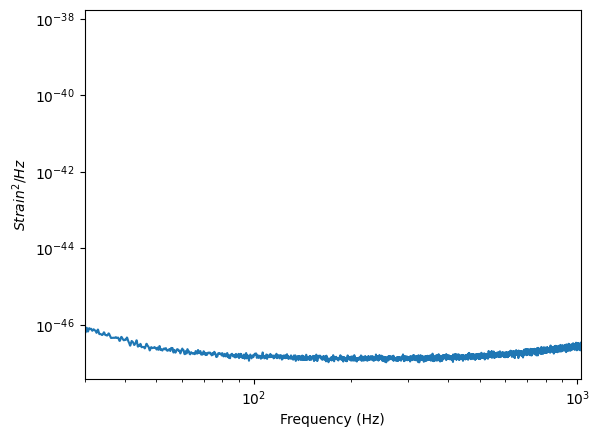

In [7]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

    pp.loglog(psd.sample_frequencies, psd)
    pp.ylabel('$Strain^2 / Hz$')
    pp.xlabel('Frequency (Hz)')
    pp.xlim(30, 1024)
    
    return psd

psd1 = psd_data(ts1)
    

# Creating Template bank

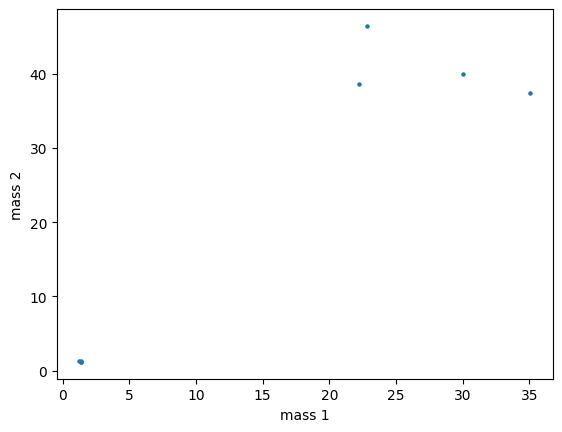

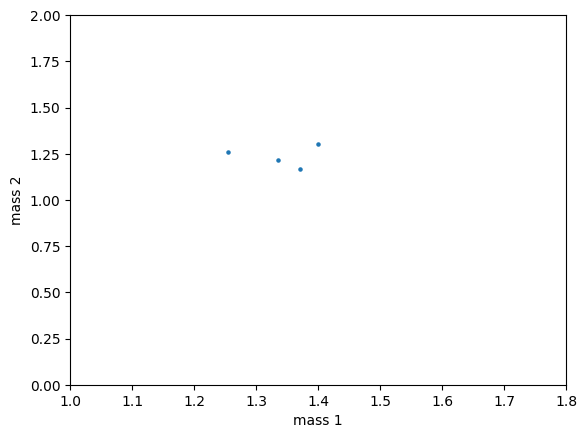

In [8]:
import numpy as np
import matplotlib.pyplot as pp

np.random.seed(0)

# BNS signal parameters
bns_m1 = 1.4
bns_m2 = 1.3
bns_radius = 0.25

# BBH signal parameters
bbh_m1 = 30
bbh_m2 = 40
bbh_radius = 10

# Number of templates per signal
num_templates = 4

# Generate templates for BNS
bns_templates = np.zeros((num_templates, 2))
for i in range(num_templates):
    r1 = np.random.uniform(0,bns_radius)
    r2 = np.random.uniform(0,(np.pi*2))           
    m1 = r1*(np.cos(r2)) + bns_m1
    m2 = r1*(np.sin(r2)) + bns_m2
    
    bns_templates[i, :] = [m1, m2]
    
bns_templates[i,:] = [bns_m1,bns_m2]

# Generate templates for BBH
bbh_templates = np.zeros((num_templates, 2))
for i in range(num_templates):
    r1 = np.random.uniform(0,bbh_radius)
    r2 = np.random.uniform(0,(np.pi*2))           
    m1 = r1*(np.cos(r2)) + bbh_m1
    m2 = r1*(np.sin(r2)) + bbh_m2
    
    bbh_templates[i, :] = [m1, m2]
    
bbh_templates[i,:] = [bbh_m1,bbh_m2]

# Combine the templates into a single bank
template_bank = np.concatenate([bns_templates, bbh_templates])

# Plot the template bank
pp.scatter(template_bank[:, 0], template_bank[:, 1], s=5)
pp.xlabel("mass 1")
pp.ylabel("mass 2")
pp.show()


pp.scatter(template_bank[:, 0], template_bank[:, 1], s=5)
pp.xlabel("mass 1")
pp.ylabel("mass 2")
pp.xlim(1.0,1.8)
pp.ylim(0,2)
pp.show()



In [9]:
 for i in range(num_templates):
    print(bns_templates[i,:])

[1.37022935 1.16606541]
[1.25526172 1.25806482]
[1.33555592 1.2159484 ]
[1.4 1.3]


In [10]:
 for i in range(num_templates):
         print(bbh_templates[i,:])

[22.83420858 46.44329302]
[22.21287256 38.57048965]
[35.07094615 37.44012353]
[30. 40.]


# Generating Template 

In [11]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
   
    return template


# Generating SNR

In [12]:
def gen_SNR(template,conditioned,psd):
    from pycbc.filter import matched_filter
    import numpy

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)



    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

   
    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    time = snr.sample_times[peak]
   
    
    return snr,time,peak,snrp

# Chi-square Test

In [13]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):
    
    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)
    
    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2
    
    
    
    return chisq


# Calculating SNR,Chi-Sq.,New SNR for entire template bank

In [14]:
bns_info = []
bbh_info = []

for i in range(num_templates):
    T1 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.05,0.05,ts1)
    
    S1,time_bns,index_peak_bns,old_snr_bns = gen_SNR(T1,ts1,psd1)

    chisq_1 = gen_chisquare(T1,ts1,bns_templates[i,:][0],bns_templates[i,:][1],0.05,0.05,psd1)
    chisq_val_bns = chisq_1[index_peak_bns]
    
    new_snr_bns = newsnr(abs(S1),chisq_1)
    
    snrp_bns = new_snr_bns[index_peak_bns]
    
    bns_info.append([bns_templates[i,:][0],bns_templates[i,:][1],time_bns,old_snr_bns,snrp_bns,chisq_val_bns])
    
    
    
    
    T2 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,ts1)
    
    S2,time_bbh,index_peak_bbh,old_snr_bbh = gen_SNR(T2,ts1,psd1)
    
    chisq_2 = gen_chisquare(T2,ts1,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd1)
    chisq_val_bbh = chisq_2[index_peak_bbh]
    
    new_snr_bbh = newsnr(abs(S2),chisq_2)
    
    snrp_bbh = new_snr_bbh[index_peak_bbh]
    
    bbh_info.append([bbh_templates[i,:][0],bbh_templates[i,:][1],time_bbh,old_snr_bbh,snrp_bbh,chisq_val_bbh])
    

In [15]:
for i in bns_info:
    print(i)


[1.3702293483143464, 1.1660654089526412, 382.919189453125, 5.628001799127941, 5.585160886204678, 1.0303461655532447]
[1.2552617153106338, 1.258064818874716, 361.462646484375, 5.3891992749497994, 5.3891992749497994, 0.9810486397265863]
[1.3355559185316246, 1.2159483957536925, 333.004150390625, 5.267964496445762, 5.267964496445762, 0.9445659205717039]
[1.4, 1.3, 255.800048828125, 7.758350086509608, 7.526116896691577, 1.1187025324362552]


In [16]:
for i in bbh_info:
    print(i)

[22.83420857992519, 46.44329301845172, 251.001220703125, 6.94635141670362, 6.685916993138753, 1.1486148074506501]
[22.2128725610292, 38.57048964959055, 398.926025390625, 5.30776607000595, 5.249433648022954, 1.0437590074786491]
[35.07094614581238, 37.44012353323244, 250.99951171875, 8.354381891679372, 8.072288647188802, 1.1338613944421734]
[30.0, 40.0, 251.000244140625, 8.635529529314473, 8.635529529314473, 0.9272549625664297]


## Combining the lists

In [17]:
total_info = [*bbh_info,*bns_info]


## Finding the first loud signal

In [19]:
info = {}
for i in total_info:
    info.update({i[4] : [i[0],i[1],i[2],i[3],i[5]]})


snrp_1 = max(info.keys())
time_1 = info.get(max(info.keys()))[2]
m1_1 = info.get(max(info.keys()))[0]
m2_1 = info.get(max(info.keys()))[1]
chi_sq_1 = info.get(max(info.keys()))[4]

print("The first signal detected is due to the following masses ",m1_1,"M and ", m2_1, "M at time ", time_1, "seconds", " with new SNR value as", snrp_1, " and chi~square value as ", chi_sq_1 )

The first signal detected is due to the following masses  30.0 M and  40.0 M at time  251.000244140625 seconds  with new SNR value as 8.635529529314473  and chi~square value as  0.9272549625664297


## Aligning and subtracting the first signal(BBH) from data

In [20]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time_1 - ts1.start_time 
temp_sub = gen_template('IMRPhenomPv2',m1_1,m2_1,0.8,0.8,ts1)
aligned = temp_sub.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd1, low_frequency_cutoff=30.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp_1).to_timeseries()
aligned.start_time = ts1.start_time


# Visualising the data and template

In [21]:
# # We do it this way so that we can whiten both the template and the data
# white_data = (ts1.to_frequencyseries() / psd1**0.5).to_timeseries()

# # apply a smoothing of the turnon of the template to avoid a transient
# # from the sharp turn on in the waveform.
# tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
# white_template = (tapered.to_frequencyseries() / psd1**0.5).to_timeseries()

# white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
# white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# # Select the time around the merger
# white_data = white_data.time_slice(255.0-0.40,255.0+0.40)
# white_template = white_template.time_slice(255.0-0.40,255.0+0.40)

# pp.figure(figsize=[15, 3])
# pp.plot(white_data.sample_times, white_data, label="Data")
# pp.plot(white_template.sample_times, white_template, label="Template")
# pp.legend()
# pp.show()

## Subtracting the BBH signal from data

Text(0, 0.5, 'Strain')

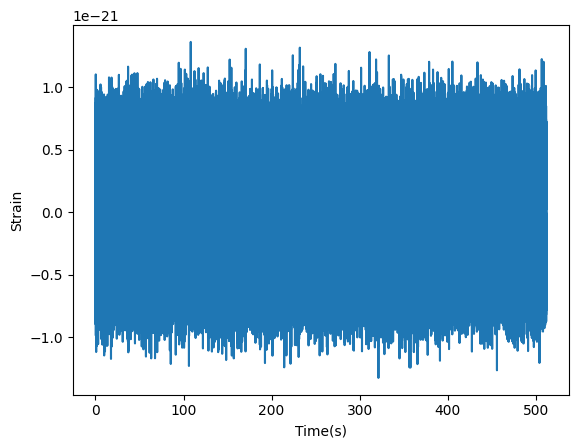

In [22]:
subtracted = ts1 - aligned

pp.plot(subtracted.sample_times,subtracted)
pp.xlabel('Time(s)')
pp.ylabel('Strain')


##### Calculating PSD of data after subtracting first signal

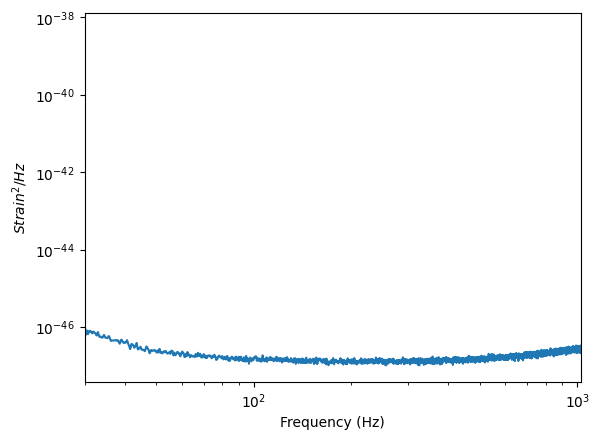

In [23]:
psd2 = psd_data(subtracted)    

# Calculating SNR,Chi-Sq.,New SNR for entire template bank after subtracting the first loud signal(BBH) detected

In [24]:
bns_info_sub = []
bbh_info_sub = []

for i in range(num_templates):
    T1 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.05,0.05,subtracted)
    
    S1,time_bns,index_peak_bns,old_snr_bns = gen_SNR(T1,subtracted,psd2)

    chisq_1 = gen_chisquare(T1,subtracted,bns_templates[i,:][0],bns_templates[i,:][1],0.05,0.05,psd2)
    chisq_val_bns = chisq_1[index_peak_bns]
    
    new_snr_bns = newsnr(abs(S1),chisq_1)
    
    snrp_bns = new_snr_bns[index_peak_bns]
    
    bns_info_sub.append([bns_templates[i,:][0],bns_templates[i,:][1],time_bns,old_snr_bns,snrp_bns,chisq_val_bns])
    
    
    
    
    T2 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,subtracted)
    
    S2,time_bbh,index_peak_bbh,old_snr_bbh = gen_SNR(T2,subtracted,psd2)
    
    chisq_2 = gen_chisquare(T2,subtracted,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd2)
    chisq_val_bbh = chisq_2[index_peak_bbh]
    
    new_snr_bbh = newsnr(abs(S2),chisq_2)
    
    snrp_bbh = new_snr_bbh[index_peak_bbh]
    
    bbh_info_sub.append([bbh_templates[i,:][0],bbh_templates[i,:][1],time_bbh,old_snr_bbh,snrp_bbh,chisq_val_bbh])

In [25]:
for i in bns_info_sub:
    print(i)

[1.3702293483143464, 1.1660654089526412, 382.919189453125, 5.6195503433290614, 5.619389180893103, 1.0001147138943107]
[1.2552617153106338, 1.258064818874716, 361.462646484375, 5.389836991677795, 5.389836991677795, 0.9352639105626009]
[1.3355559185316246, 1.2159483957536925, 333.004150390625, 5.275271310067864, 5.275271310067864, 0.9532996638427299]
[1.4, 1.3, 255.800048828125, 7.672655259137318, 7.529419287670052, 1.0741690369633894]


In [26]:
for i in bbh_info_sub:
    print(i)


[22.83420857992519, 46.44329301845172, 504.40576171875, 5.009423456424585, 5.009423456424585, 0.9385794491377787]
[22.2128725610292, 38.57048964959055, 398.926025390625, 5.314873470693814, 5.292142711736094, 1.0170731553753867]
[35.07094614581238, 37.44012353323244, 240.379638671875, 5.097078747944844, 5.097078747944844, 0.9973144588821035]
[30.0, 40.0, 240.38037109375, 5.128863058826886, 5.069752634490238, 1.0458811833060728]


## Combining the lists

In [27]:
total_info_sub = [*bbh_info_sub,*bns_info_sub]

## Finding the second loud signal

In [28]:
info_sub = {}
for i in total_info_sub:
    info_sub.update({i[4] : [i[0],i[1],i[2],i[3],i[5]]})


snrp_2 = max(info_sub.keys())
time_2 = info_sub.get(max(info_sub.keys()))[2]
m1_2 = info_sub.get(max(info_sub.keys()))[0]
m2_2 = info_sub.get(max(info_sub.keys()))[1]
chi_sq_2 = info_sub.get(max(info_sub.keys()))[4]

print("The second signal detected is due to the following masses ",m1_2,"M and ", m2_2, "M at time ", time_2, "seconds", "     with new SNR value as", snrp_2, " and chi~square value as ", chi_sq_2 )

The second signal detected is due to the following masses  1.4 M and  1.3 M at time  255.800048828125 seconds      with new SNR value as 7.529419287670052  and chi~square value as  1.0741690369633894


## Aligning and subtracting the second signal(BNS) from data

In [29]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time_2 - ts1.start_time 
temp_sub_sub = gen_template('TaylorF2',m1_2,m2_2,0.05,0.05,ts1)
aligned = temp_sub_sub.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd1, low_frequency_cutoff=30.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp_2).to_timeseries()
aligned.start_time = ts1.start_time


## Visualising the data and the template

In [30]:
# # We do it this way so that we can whiten both the template and the data
# white_data = (ts1.to_frequencyseries() / psd1**0.5).to_timeseries()

# # apply a smoothing of the turnon of the template to avoid a transient
# # from the sharp turn on in the waveform.
# tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
# white_template = (tapered.to_frequencyseries() / psd1**0.5).to_timeseries()

# white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
# white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# # Select the time around the merger
# white_data = white_data.time_slice(255.6,256)
# white_template = white_template.time_slice(255.6,256)

# pp.figure(figsize=[15, 3])
# pp.plot(white_data.sample_times, white_data, label="Data")
# pp.plot(white_template.sample_times, white_template, label="Template")
# pp.legend()
# pp.show()

## Subtracting the BNS signal from data

Text(0, 0.5, 'Strain')

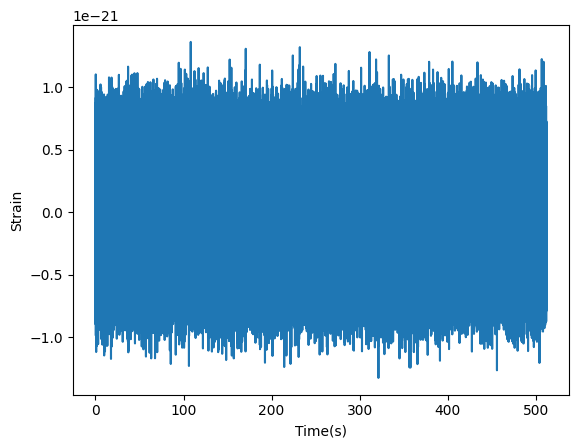

In [31]:
subtracted_sub = ts1 - aligned

pp.plot(subtracted_sub.sample_times,subtracted_sub)
pp.xlabel('Time(s)')
pp.ylabel('Strain')


### Calculating psd of data after subtracting second signal

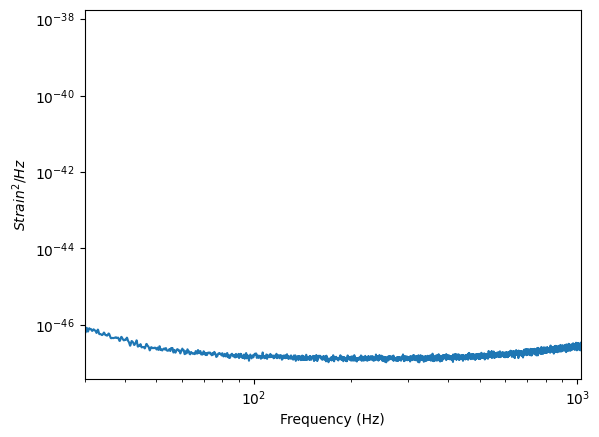

In [32]:
psd3 = psd_data(subtracted_sub)

## Calculating SNR,Chi-Sq.,New SNR for entire template bank after subtracting the second loud signal(BNS) detected

In [33]:
bns_info_sub_sub = []
bbh_info_sub_sub = []

for i in range(num_templates):
    T1 = gen_template('TaylorF2',bns_templates[i][0],bns_templates[i][1],0.05,0.05,subtracted_sub)
    
    S1,time_bns,index_peak_bns,old_snr_bns = gen_SNR(T1,subtracted_sub,psd2)

    chisq_1 = gen_chisquare(T1,subtracted_sub,bns_templates[i,:][0],bns_templates[i,:][1],0.05,0.05,psd3)
    chisq_val_bns = chisq_1[index_peak_bns]
    
    new_snr_bns = newsnr(abs(S1),chisq_1)
    
    snrp_bns = new_snr_bns[index_peak_bns]
    
    bns_info_sub_sub.append([bns_templates[i,:][0],bns_templates[i,:][1],time_bns,old_snr_bns,snrp_bns,chisq_val_bns])
    
    
    
    
    T2 = gen_template('IMRPhenomPv2',bbh_templates[i][0],bbh_templates[i][1],0.8,0.8,subtracted_sub)
    
    S2,time_bbh,index_peak_bbh,old_snr_bbh = gen_SNR(T2,subtracted_sub,psd2)
    
    chisq_2 = gen_chisquare(T2,subtracted_sub,bbh_templates[i,:][0],bbh_templates[i,:][1],0.8,0.8,psd3)
    chisq_val_bbh = chisq_2[index_peak_bbh]
    
    new_snr_bbh = newsnr(abs(S2),chisq_2)
    
    snrp_bbh = new_snr_bbh[index_peak_bbh]
    
    bbh_info_sub_sub.append([bbh_templates[i,:][0],bbh_templates[i,:][1],time_bbh,old_snr_bbh,snrp_bbh,chisq_val_bbh])

In [34]:
for i in bns_info_sub_sub:
    print(i)

[1.3702293483143464, 1.1660654089526412, 382.919189453125, 5.619688485184194, 5.619688485184194, 0.9949152662716979]
[1.2552617153106338, 1.258064818874716, 361.462646484375, 5.389644037746976, 5.389644037746976, 0.9461699473867435]
[1.3355559185316246, 1.2159483957536925, 333.004150390625, 5.2753231804973755, 5.2753231804973755, 0.9529594477668304]
[1.4, 1.3, 110.78271484375, 5.392954653181254, 5.348689959796451, 1.0327138320950453]


In [35]:
for i in bbh_info_sub_sub:
    print(i)

[22.83420857992519, 46.44329301845172, 251.001220703125, 6.970252595693719, 6.707412100582777, 1.1494730634701633]
[22.2128725610292, 38.57048964959055, 398.926025390625, 5.314867837831876, 5.314867837831876, 0.9991443442683622]
[35.07094614581238, 37.44012353323244, 250.99951171875, 8.297065404747881, 8.100772942909925, 1.093897379888267]
[30.0, 40.0, 251.000244140625, 8.61124127005103, 8.61124127005103, 0.8804397674320714]


## Combining the lists

In [36]:
total_info_sub_sub = [*bbh_info_sub_sub,*bns_info_sub_sub]

## Having subtracted the BNS signal from data finding the other signal(BBH) present in data

In [37]:
info_sub_sub = {}
for i in total_info_sub_sub:
    info_sub_sub.update({i[4] : [i[0],i[1],i[2],i[3],i[5]]})


snrp_3 = max(info_sub_sub .keys())
time_3 = info_sub_sub .get(max(info_sub_sub .keys()))[2]
m1_3 = info_sub_sub .get(max(info_sub_sub .keys()))[0]
m2_3 = info_sub_sub .get(max(info_sub_sub .keys()))[1]
chi_sq_3 = info_sub_sub .get(max(info_sub_sub .keys()))[4]

print("After subtracting the second signal(BNS),the signal detected  is due to the following masses ",m1_3,"M and ", m2_3, "M  at time ", time_3, "seconds", " with new SNR value as", snrp_3, " and chi~square value as ", chi_sq_3 )

After subtracting the second signal(BNS),the signal detected  is due to the following masses  30.0 M and  40.0 M  at time  251.000244140625 seconds  with new SNR value as 8.61124127005103  and chi~square value as  0.8804397674320714


In [38]:
print("When both signals(BBH + BNS) are present in data:")
print("The best matched template has the following parameters-")
print("Mass 1 = ",m1_1,"M" ", Mass 2 = ",m2_1,"M" ", New SNR = ",snrp_1, " Chi-square = ",chi_sq_1)

print("                                                                                            ")

print("After subtracting BBH signal from the data:")
print("The best matched template has the following parameters-")
print("Mass 1 = ",m1_2,"M" ", Mass 2 = ",m2_2,"M" ", New SNR = ",snrp_2, " Chi-square = ",chi_sq_2)

print("                                                                                            ")

print("After subtracting BNS signal from the data:")
print("The best matched template has the following parameters-")
print("Mass 1 = ",m1_3,"M" ", Mass 2 = ",m2_3,"M" ", New SNR = ",snrp_3, " Chi-square = ",chi_sq_3)



When both signals(BBH + BNS) are present in data:
The best matched template has the following parameters-
Mass 1 =  30.0 M, Mass 2 =  40.0 M, New SNR =  8.635529529314473  Chi-square =  0.9272549625664297
                                                                                            
After subtracting BBH signal from the data:
The best matched template has the following parameters-
Mass 1 =  1.4 M, Mass 2 =  1.3 M, New SNR =  7.529419287670052  Chi-square =  1.0741690369633894
                                                                                            
After subtracting BNS signal from the data:
The best matched template has the following parameters-
Mass 1 =  30.0 M, Mass 2 =  40.0 M, New SNR =  8.61124127005103  Chi-square =  0.8804397674320714
